# Funzioni Da Importare

In [ ]:
#!pip install ipywidgets
#!pip install ipympl

#!pip install ipywidgets==7.7.1
#!pip install --upgrade ipywidgets
#!pip install --upgrade matplotlib ipympl
#!pip uninstall ipympl ipywidgets matplotlib
!pip install ipywidgets==7.7.1
!pip install matplotlib==3.10.0
!pip install ipympl==0.9.6
#%matplotlib widgets

KeyError: 'gtk3agg'

In [ ]:

import numpy as np
import astropy.units as u
from scipy.optimize import curve_fit
from ipywidgets import interactive, IntSlider , Layout
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import output
output.enable_custom_widget_manager()




plt.rcParams['figure.max_open_warning'] = 0





def dispersion_delay(fstart, fstop, dms = None):
    """
    Returns DM-delay in seconds
    """
    return (
        4148808.0
        * dms
        * (1 / fstart ** 2 - 1 / fstop ** 2)
        / 1000
    )


def dedisperse(wfall, DM, freq, dt, ref_freq="bottom"):

    """
    Dedisperse a waterfaller matrix to DM.
    """

    k_DM = 1. / 2.41e-4
    dedisp = np.zeros_like(wfall)

    # pick reference frequency for dedispersion
    if ref_freq == "top":
        reference_frequency = freq[-1]
    elif ref_freq == "center":
        center_idx = len(freq) // 2
        reference_frequency = freq[center_idx]
    elif ref_freq == "bottom":
        reference_frequency = freq[0]
    else:
        #print "`ref_freq` not recognized, using 'top'"
        reference_frequency = freq[-1]

    shift = (k_DM * DM * (reference_frequency**-2 - freq**-2) / dt).round().astype(int)
    for i,ts in enumerate(wfall):
        dedisp[i] = np.roll(ts, shift[i])


    return dedisp

def gauss(x,a,x0,sigma):

    """
    Simple Gaussian Function.
    """

    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def get_width(time,timeseries):

    """
    Function to get the width of a burst from a Gaussian fit.
    """


    tmax = time[np.argmax(timeseries)]
    par_time_opt,par_time_cov = curve_fit(gauss,time,timeseries, p0=[np.max(timeseries),tmax,0.1 * np.max(time)])

    sigma_t = np.abs(par_time_opt[2])

    W = 2.355 * sigma_t

    return W

def test_FRB(
    nchan = 100,
    nbin = 10000,
    fc = 600 * u.MHz,
    bw = 400 * u.MHz,
    obsduration = 120 * u.s,
    ):
    df = bw / nchan
    dt = obsduration / nbin

    data = np.zeros((nchan, nbin) , dtype = float)

    freqs = np.linspace(fc.value + bw.value / 2 , fc.value - bw.value / 2, nchan)
    times = np.linspace(0, obsduration.value , nbin)

    dm = 349
    delaytot = np.abs(dispersion_delay(freqs[-1], freqs[0], dms = dm))
    tburst = 35.5 * u.s
    fburst = fc * u.MHz
    width_t = np.random.uniform(1,50) * u.ms
    width_f = np.random.uniform(50, bw.value) * u.MHz
    sigma_f = width_f.value / 2.355
    sigma_t = width_t.to(u.s).value / 2.355
    If = gauss(freqs, 1 , fburst.value, sigma_f)
    A = 2


    for chan, f in enumerate(freqs):

        delay = dispersion_delay(f, freqs[0], dms = dm)
        data[chan,:] = A*If[chan]*gauss(times, 1, (tburst.value + delay ) , sigma_t) + np.random.normal(0,0.1, size = data.shape[1])

    rfi_idxs = np.array([5,12,28,32,34])

    for rfi_idx in rfi_idxs:

        data[rfi_idx, :]  = 10 * A

    return tburst,dm,data



def simulate_FRB(
    nchan = 100,
    nbin = 10000,
    fc = 600 * u.MHz,
    bw = 400 * u.MHz,
    obsduration = 120 * u.s,
    ):
    df = bw / nchan
    dt = obsduration / nbin

    data = np.zeros((nchan, nbin) , dtype = float)

    freqs = np.linspace(fc.value + bw.value / 2 , fc.value - bw.value / 2, nchan)
    times = np.linspace(0, obsduration.value , nbin)

    dm = int(np.random.uniform(100,1000))#20 * np.random.noncentral_chisquare(1, 10)
    delaytot = np.abs(dispersion_delay(freqs[-1], freqs[0], dms = dm))
    tburst = np.random.uniform(5, obsduration.value-delaytot) * u.s
    fburst = np.random.uniform(freqs[-1],freqs[0]) * u.MHz
    width_t = np.random.uniform(1,50) * u.ms
    width_f = np.random.uniform(50, bw.value) * u.MHz
    sigma_f = width_f.value / 2.355
    sigma_t = width_t.to(u.s).value / 2.355
    If = gauss(freqs, 1 , fburst.value, sigma_f)
    A = np.random.uniform(0.1,10)


    for chan, f in enumerate(freqs):

        delay = dispersion_delay(f, freqs[0], dms = dm)
        data[chan,:] = A*If[chan]*gauss(times, 1, (tburst.value + delay ) , sigma_t) + np.random.normal(0,0.1, size = data.shape[1])

    rfi_idxs = np.random.choice(np.arange(0, data.shape[0]), np.random.randint(0,10), replace=False)

    for rfi_idx in rfi_idxs:

        data[rfi_idx, :]  = np.random.uniform(1,20) * A


    return tburst,dm,data

class FRBFILE:

    """
    Create a FRBFILE Object

    data : Basic Total Intensity data, a numpy array
    telescope : The telescope  which "recorded" the data
    duration : length of the observation
    fc : central frequency of the observation
    bw : bandwidth of the observation
    df : spectral resolution of the data
    dt : time resolution of the data
    """

    def __init__(
    self,
    data,
    telescope,
    duration,
    fc,
    bw,
    tburst,
    dm,
    df,
    dt,
    ):

        self.telescope = telescope
        self.fc = fc
        self.bw = bw
        self.dm = dm
        self.df = df
        self.dt = dt
        self.data = data
        self.duration = duration
        self.tburst = tburst


    def get_dm(self):

        return self.dm.value

    def header(self):

        string =  f"""


 Observational Specifics \n

 Telescope                            = {self.telescope}
 Central Frequency                    = {self.fc.value} {self.fc.unit}
 Bandwidth                            = {self.bw.value} {self.bw.unit}
 \n
 Data Information \n

 Data length                          = {self.duration.value} {self.duration.unit}
 Time resolution                      = {self.dt.value} {self.dt.unit}
 Frequency resolution                 = {self.df.value} {self.df.unit}
 Data Shape (freq chans, times bins)  = {self.data.shape}

        """

        return string

    def reveal(self):
        DM = self.dm * u.pc / u.cm**3

        string =  f"""


 The FRB Hidden in this File has: \n

 DM = {DM.value} {DM.unit}
 Burst Time  = {self.tburst.value} {self.tburst.unit}

        """

        return string

    def get_data(self):

      return self.data

    def get_lightcurve(self):

      return self.data.mean(0)

    def find_peak(self, start = 0, stop = 100):

      data = self.data
      duration = self.duration.value
      dt = self.dt.value

      lightcurve = self.get_lightcurve()
      times = np.linspace(0, duration, lightcurve.shape[0])
      startbin = int(start / dt)
      stopbin  = int(stop / dt)
      lightcurve = lightcurve[startbin:stopbin]
      times = times[startbin:stopbin]
      apeak = np.argmax(lightcurve)
      peak  = times[apeak]

      print(f"The Peak is at {peak:.3f} s")


    def plot_observation(self, start = 0, stop = 100):

      data = self.data
      fc = self.fc.value
      bw = self.bw.value
      duration = self.duration.value
      dt = self.dt.value

      plt.figure(figsize = (40,10))
      plt.rc('axes', linewidth = 1)

      widths  = [1]
      heights = [0.3,0.7]

      gs = plt.GridSpec(2,1, hspace = 0.0 , wspace = 0.0,  width_ratios = widths, height_ratios = heights, top = 0.99 , bottom = 0.2, right = 0.9, left = 0.2)

      ax0 = plt.subplot(gs[0,0])
      ax1 = plt.subplot(gs[1,0])

      ax0.set_xticks([])


      size = 20
      ax0.margins(x = 0)
      ax1.margins(x = 0)
      ax0.tick_params(labelsize  = size, length = 5, width = 1)
      ax1.tick_params(labelsize  = size, length = 5, width = 1)

      ax0.set_ylabel(r"Flux (Arbitrary)", size = size)
      ax1.set_xlabel(r"Time (s)", size = size)
      ax1.set_ylabel(r"Frequency (MHz)" , size = size)

      freqs = np.linspace(fc + bw / 2, fc - bw / 2, data.shape[0])

      startbin = int(start / dt)

      stopbin  = int(stop / dt)

      dataplot = data[:, startbin : stopbin]

      times = np.linspace(start, stop, dataplot.shape[1])

      lightcurve = dataplot.mean(0)

      ax0.plot(times, lightcurve, color = "darkblue", linewidth = 2)

      ax1.imshow(dataplot , aspect = "auto", extent = (times[0], times[-1], freqs[-1], freqs[0]))

      ax1.locator_params(axis='x', nbins=25)

      plt.show()

def clean_file(frbfile,channels):

    channels = np.array(channels)

    data = frbfile.data
    fc = frbfile.fc
    bw = frbfile.bw
    dt = frbfile.dt
    df = frbfile.df
    telescope = frbfile.telescope
    tburst = frbfile.tburst
    duration = frbfile.duration
    dm = frbfile.dm

    data[channels,:] = np.nan

    cleanfile = FRBFILE(data,telescope,duration,fc,bw,tburst,dm,df,dt)

    return cleanfile

def dedisp_file(frbfile, dm = 0):

    data = frbfile.data
    fc = frbfile.fc
    bw = frbfile.bw
    #dm = frbfile.dm
    dt = frbfile.dt
    df = frbfile.df
    telescope = frbfile.telescope
    tburst = frbfile.tburst
    duration = frbfile.duration


    freqs = np.linspace(fc.value + bw.value /2 , fc.value - bw.value / 2, data.shape[0])

    dedispdata = dedisperse(data, dm, freqs, dt.value, ref_freq="bottom")

    data = dedispdata


    dedispfile = FRBFILE(data,telescope,duration,fc,bw,tburst,dm,df,dt)


    return dedispfile

def make_observation(
    telescope = "SRT (P-band)",
    fc = 336 * u.MHz,
    bw = 80 * u.MHz,
    df = 2 * u.MHz,
    dt = 0.01 * u.s,
    duration = 100 * u.s,
    ):

    nchan = int(bw.value / df.value)
    nbin = int(duration.value / dt.value)

    tburst, dm, data = simulate_FRB(nbin = nbin, nchan = nchan, fc = fc, bw = bw, obsduration = duration)

    r = np.random.uniform(0,1)

    if r >= 0.33:
       srtfile =  FRBFILE(data,telescope,duration,fc,bw,tburst,dm,df,dt)
    else:
       srtfile =  FRBFILE(np.random.normal(0,1,size = data.shape),telescope,duration,fc,bw,0*u.s,0,df,dt)

    return srtfile



def make_test(
    telescope = "SRT (P-band)",
    fc = 336 * u.MHz,
    bw = 80 * u.MHz,
    df = 2 * u.MHz,
    dt = 0.01 * u.s,
    duration = 100 * u.s,
    ):

    nchan = int(bw.value / df.value)
    nbin = int(duration.value / dt.value)

    tburst, dm, data = test_FRB(nbin = nbin, nchan = nchan, fc = fc, bw = bw, obsduration = duration)

    srtfile =  FRBFILE(data,telescope,duration,fc,bw,tburst,dm,df,dt)

    return srtfile

def rfi_zap(frbfile):

    image = frbfile.data
    fc = frbfile.fc
    bw = frbfile.bw
    dt = frbfile.dt
    df = frbfile.df
    telescope = frbfile.telescope
    tburst = frbfile.tburst
    duration = frbfile.duration
    dm = frbfile.dm
    freqs = np.linspace(fc.value + bw.value /2 , fc.value - bw.value / 2, image.shape[0])
    times = np.linspace(0, duration.value, image.shape[1])

    fig = plt.figure(figsize = (12,6))
    plt.subplots_adjust(left=0.02, right=0.98, top=0.99, bottom=0.02)
    plt.rc('axes', linewidth = 1)
    widths  = [1]
    heights = [1]

    gs = plt.GridSpec(1,1, hspace = 0.0 , wspace = 0.0,  width_ratios = widths, height_ratios = heights, top = 0.99 , bottom = 0.1, right = 0.95, left = 0.05)
    ax0 = plt.subplot(gs[0,0])
    #ax0.set_xticks([])
    size = 10
    ax0.margins(x = 0)
    ax0.tick_params(labelsize  = size, length = 5, width = 1)


    ax0.set_xlabel(r"Time (s)", size = size)
    ax0.set_ylabel(r"Frequency (MHz)" , size = size)



    im = ax0.imshow(image , aspect = "auto", extent = (times[0], times[-1], freqs[-1], freqs[0]))


    ax2 = ax0.twinx()
    ax2.set_ylabel("Frequency Channel", size=size)
    ax2.set_yticks((np.arange(0,image.shape[0] + 1, 5)))
    ax2.tick_params(labelsize  = size, length = 5, width = 1)
    ax2.set_yticklabels(np.flip(np.arange(0,image.shape[0] + 1, 5)))

    def on_click(event):
        if event.inaxes is not None:
            x, y = int(round(event.xdata)), int(round(image.shape[0] - event.ydata))
            image[y, :] = np.nan  # Set the clicked pixel to NaN
            im.set_array(image)
            plt.draw()
            clear_output(wait=True)
            plt.show()
            #dataclean = np.copy(image)
            cleanfile = FRBFILE(image,telescope,duration,fc,bw,tburst,dm,df,dt)
            #return image

    fig.canvas.mpl_connect('button_press_event', on_click)
    #plt.show()


    cleanfile = FRBFILE(image,telescope,duration,fc,bw,tburst,dm,df,dt)

    return cleanfile
from matplotlib.ticker import MaxNLocator

def play_observation(frbfile):
    data = frbfile.data
    fc = frbfile.fc
    bw = frbfile.bw
    dt = frbfile.dt
    df = frbfile.df
    telescope = frbfile.telescope
    tburst = frbfile.tburst
    duration = frbfile.duration

    freqs = np.linspace(fc.value + bw.value /2 , fc.value - bw.value / 2, data.shape[0])
    times = np.linspace(0, duration.value, data.shape[1])


    def show_cand(start, dm):
        stop = start + 5
        plt.figure(figsize = (12,6))
        plt.rc('axes', linewidth = 1)
        widths  = [1]
        heights = [0.3,0.7]

        gs = plt.GridSpec(2,1, hspace = 0.0 , wspace = 0.0,  width_ratios = widths, height_ratios = heights, top = 0.99 , bottom = 0.1, right = 0.95, left = 0.05)

        ax0 = plt.subplot(gs[0,0])
        ax1 = plt.subplot(gs[1,0])
        ax0.xaxis.set_major_locator(MaxNLocator(nbins=5))

        ax0.set_xticks([])


        size = 10
        ax0.margins(x = 0)
        ax1.margins(x = 0)
        ax0.tick_params(labelsize  = size, length = 5, width = 1)
        ax1.tick_params(labelsize  = size, length = 5, width = 1)

        ax0.set_ylabel(r"Flux (Arbitrary)", size = size)
        ax0.set_yticks([])
        ax1.set_xlabel(r"Time (s)", size = size)
        ax1.set_ylabel(r"Frequency (MHz)" , size = size)

        startbin = int(start / dt.value)

        stopbin  = int(stop / dt.value)

        dedispdata = dedisperse(data, dm, freqs, dt.value, ref_freq="bottom")

        dataplot = dedispdata[:, startbin : stopbin]

        times = np.linspace(start, stop, dataplot.shape[1])

        #lightcurve = dataplot.mean(0)
        lightcurve = np.nanmean(dataplot, axis = 0)

        ax0.plot(times, lightcurve, color = "darkblue", linewidth = 2)

        ax1.imshow(dataplot , aspect = "auto", extent = (times[0], times[-1], freqs[-1], freqs[0]))

        ax1.locator_params(axis='x', nbins=25)

        ax2 = ax1.twinx()
        ax2.set_ylabel("Frequency Channel", size=size)
        ax2.set_yticks((np.arange(0,data.shape[0] + 1, 5)))
        ax2.tick_params(labelsize  = size, length = 5, width = 1)
        ax2.set_yticklabels(np.flip(np.arange(0,data.shape[0] + 1, 5)))


        plt.show()
    interactive_plot = interactive(show_cand, start=IntSlider(0, 0, 100, 5, layout=Layout(width='1000px')), dm=IntSlider(0, 0, 1000, 1, layout=Layout(width='1000px')) ) # tstart = (0.0 , 25,5), DM = (0,1000,1))
    output = interactive_plot.children[-1]
    output.layout.height = '700px'


    return interactive_plot

# Facciamo un Prova!


Questo file è una piccola osservazione simulata di $100 \ \rm {s}$ la quale contiene burst di FRB 20180916B che normalmente una persona vedrebbe con il Sardinia Radio Telescope. Il burst si trova a 35.5 s l'FRB ha una DM di circa $349 \ {\rm pc \times cm^{-3}}$.

Carichiamo il file!

In [ ]:
testfile = make_test()

Andiamolo a scovare e correggiamo la DM. Possiamo usare queste due barre interattive. La prima ci permette di esplorare il dato, visualizzandone $5 \ {\rm s}$ alla volta. La seconda ci permette di selezionare un valore di DM e correggere il segnale per cercare di raddrizzarlo!

In [ ]:
play_observation(testfile)

interactive(children=(IntSlider(value=0, description='start', layout=Layout(width='1000px'), step=5), IntSlide…

# Rimozione delle interferenze (Radio Frequency Interference, RFI)

Dall'immagine sopra si vede chiaramente che alcuni canali di frequenza sono corrotti da fortissimi segnali interferenti (gli RFI). Gli RFI sono nella maggior parte dei casi creati da noi (comunicazioni satellitari, cellulari etc.) e possono severamente indebolire i segnali che andiamo a cercare. E' necessario quindi cercare di rimuoverli dai nostri dati!

Tramite la funzione rfi_zap() potrete andare a cliccare e rimovere le fastidiose interferenze!

In [ ]:
cleanfile = clean_file(testfile, channels = [5, 12, 28, 32, 34])

In [ ]:
play_observation(cleanfile)

interactive(children=(IntSlider(value=0, description='start', layout=Layout(width='1000px'), step=5), IntSlide…

Ora va molto meglio!

# Ora Tocca a te!

Qui dentro ci sarà un FRB incognito starà a voi trovarlo con il plot interattivo!

In [ ]:
mysteryfile = make_observation()

In [ ]:
play_observation(mysteryfile)

interactive(children=(IntSlider(value=0, description='start', layout=Layout(width='1000px'), step=5), IntSlide…

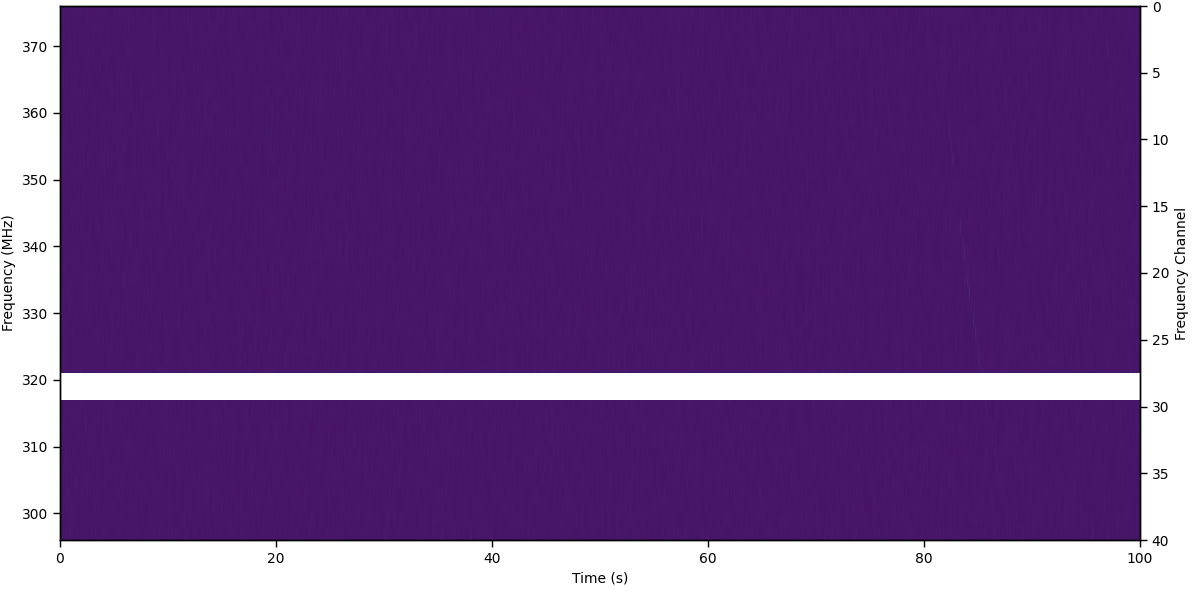

In [ ]:
mysterycleanfile = clean_file(mysteryfile, channels = []) # Fill here the corrupted channels!

In [ ]:
play_observation(mysterycleanfile)

interactive(children=(IntSlider(value=0, description='start', layout=Layout(width='1000px'), step=5), IntSlide…

Dopo che avrete fatto un po' di prove vi sveleremo come scoprire se i vostri risultati sono corretti!

In [ ]:
mysteryfile.reveal()

'\n\n\n The FRB Hidden in this File has: \n\n\n DM = 372.0 pc / cm3\n Burst Time  = 81.22050632295543 s\n\n        '